In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import sys, os

In [15]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 250.0 * 2 - 1, x_test / 250.0 * 2 - 1
print('X Train shape: ', x_train.shape) 

X Train shape:  (60000, 28, 28)


In [16]:
#Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [17]:
#Dimensionality of Z, Latent Space:
latent_dim = 100

In [18]:
def build_generator(latent_dim, D):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha = 0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha = 0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha = 0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)
  model = Model(i,x)
  return model

def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i,x)
  return model

In [19]:
#Compile both models in preparation of training
#Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(0.0002, 0.5),
    metrics = ['accuracy'])

generator = build_generator(latent_dim, D)
# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
img = generator(z)
#Don't train Discriminator
discriminator.trainable = False
#Label output to real, so it can be train:
fake_pred = discriminator(img)
combined_model = Model(z, fake_pred)
combined_model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(0.0002, 0.5))

In [20]:
#TRAIN GAN:
batch_size = 32
epochs = 30000
sample_period = 200 #every sample period steps generate and save some data

#Creates batch_labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
# Store the losses
d_losses = []
g_losses = []

#Create a folder to store generated image
if not os.path.exists('gan_images'):
  os.makedirs('gan_images') 

In [21]:
#A function to generate a grid of random samples from the generator and save them to a file:
def sample_images(epoch):
  rows, cols = 5,5 
  noise = np.random.randn(rows*cols, latent_dim)
  imgs = generator.predict(noise)
  #Rescale images
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
      axs[i,j].axis('off')
      idx +=1
  fig.savefig('gan_images/%d.png'% epoch)
  plt.close() 

In [22]:
#Main Training Load:
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  #Train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)
  # Train generator

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    sample_images(epoch) 

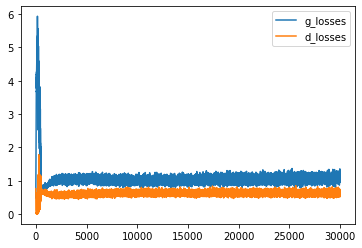

In [23]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [24]:
!ls gan_images

0.png	   13700.png  17600.png  21400.png  25300.png  29200.png  6100.png
10000.png  13800.png  17700.png  21500.png  25400.png  29300.png  6200.png
1000.png   13900.png  17800.png  21600.png  25500.png  29400.png  6300.png
100.png    14000.png  17900.png  21700.png  25600.png  29500.png  6400.png
10100.png  1400.png   18000.png  21800.png  25700.png  29600.png  6500.png
10200.png  14100.png  1800.png	 21900.png  25800.png  29700.png  6600.png
10300.png  14200.png  18100.png  22000.png  25900.png  29800.png  6700.png
10400.png  14300.png  18200.png  2200.png   26000.png  29900.png  6800.png
10500.png  14400.png  18300.png  22100.png  2600.png   3000.png   6900.png
10600.png  14500.png  18400.png  22200.png  26100.png  300.png	  7000.png
10700.png  14600.png  18500.png  22300.png  26200.png  3100.png   700.png
10800.png  14700.png  18600.png  22400.png  26300.png  3200.png   7100.png
10900.png  14800.png  18700.png  22500.png  26400.png  3300.png   7200.png
11000.png  14900.png  18800.pn

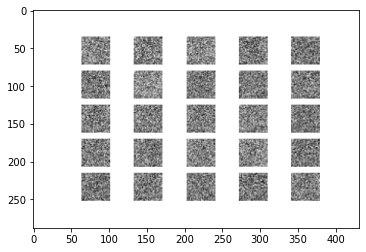

In [25]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

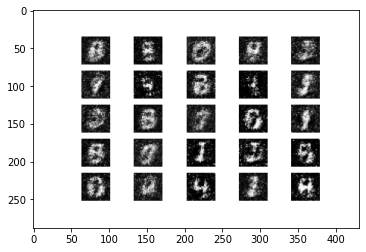

In [26]:
a = imread('gan_images/1000.png')
plt.imshow(a)

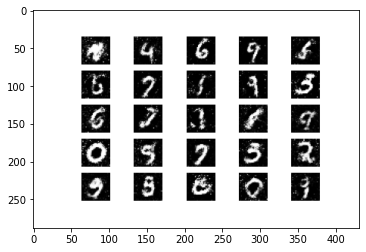

In [27]:
a = imread('gan_images/5000.png')
plt.imshow(a)

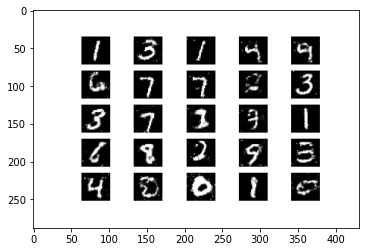

In [28]:
a = imread('gan_images/20000.png')
plt.imshow(a)

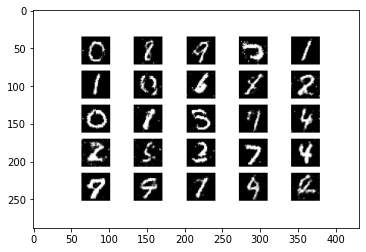

In [29]:
a = imread('gan_images/29800.png')
plt.imshow(a)